In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import os

In [3]:
print(os.getcwd())

/Users/jackkalsched/Desktop/Independent Projects/SMT-Data-Challenge-2025


In [4]:
#Filtering game_info for plays that have a runner on base
## Assuming that we are only accounting for plays with a runner on base, looking to advance to third/home.
runners_df = pd.read_csv('game_info/QEA/ACN/year_1/day_070/game_info.csv')
runners_df['runner_on'] = (runners_df['first_baserunner'].notnull()) | (runners_df['second_baserunner'].notnull()) | (runners_df['third_baserunner'].notnull()) 
runners_df = runners_df[runners_df['runner_on'] == True]

runners_df


,game_str,home_team,away_team,at_bat,play_per_game,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,runner_on
6,y1_d070_ACN_QEA,QEA,ACN,NaN,7,top,QEA-0175,QEA-0120,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0424,QEA-0365,QEA-0249,ACN-1416,ACN-1623,NaN,NaN,True
7,y1_d070_ACN_QEA,QEA,ACN,2.0,8,top,QEA-0175,QEA-0120,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0424,QEA-0365,QEA-0249,ACN-1416,ACN-1623,NaN,NaN,True
8,y1_d070_ACN_QEA,QEA,ACN,2.0,9,top,QEA-0175,QEA-0120,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0424,QEA-0365,QEA-0249,ACN-1416,ACN-1623,NaN,NaN,True
9,y1_d070_ACN_QEA,QEA,ACN,2.0,11,top,QEA-0175,QEA-0120,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0424,QEA-0365,QEA-0249,ACN-1416,ACN-1623,NaN,NaN,True
10,y1_d070_ACN_QEA,QEA,ACN,2.0,12,top,QEA-0175,QEA-0120,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0424,QEA-0365,QEA-0249,ACN-1416,ACN-1623,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,y1_d070_ACN_QEA,QEA,ACN,72.0,300,top,QEA-0108,QEA-0120,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-1416,ACN-1623,NaN,NaN,True
295,y1_d070_ACN_QEA,QEA,ACN,72.0,301,top,QEA-0108,QEA-0120,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-1180,ACN-1623,NaN,NaN,True
296,y1_d070_ACN_QEA,QEA,ACN,73.0,302,top,QEA-0108,QEA-0120,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-1180,ACN-1623,NaN,NaN,True
297,y1_d070_ACN_QEA,QEA,ACN,73.0,303,top,QEA-0108,QEA-0120,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-1180,NaN,ACN-1623,NaN,True


How do we determine plays in which the runner is trying to reach the next base? 

First, the ball needs to be hit in play.

In [5]:
batted_balls = pd.read_csv('game_events/QEA/ACN/year_1/day_070/game_events.csv')


#Filtering for plays that aren't just pitch -> throw back to pitcher -> end play
prev2 = batted_balls['event_code'].shift(2)
prev1 = batted_balls['event_code'].shift(1)
curr  = batted_balls['event_code']
next1 = batted_balls['event_code'].shift(-1)
next2 = batted_balls['event_code'].shift(-2)

pattern1 = (curr == 5) & (prev1 == 2) & (prev2 == 1)   
pattern2 = (curr == 1) & (next1 == 2) & (next2 == 5)   
pattern3 = (curr == 2) & (prev1 == 1) & (next1 == 5) 
pattern4 = (curr == 5) & (prev1 == 4) #foulball (hit ball, end of play)
pattern5 = (curr == 4) & (next1 == 5) #foulball
pattern6 = (curr == 1)

batted_balls['non_play'] = pattern1 | pattern2 | pattern3 | pattern4 | pattern5 | pattern6

#filter for play_id's that have event_code 4 in them (batted ball)
bbip = batted_balls.groupby('play_id')['event_code'].apply(lambda x: (x == 4).any())
filtered_batted_balls = batted_balls[batted_balls['play_id'].isin(bbip[bbip].index)]

filtered_batted_balls = filtered_batted_balls[filtered_batted_balls['non_play'] == False]

filtered_batted_balls.head(15)



,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,non_play
16,y1_d070_ACN_QEA,6,1,6,112287,10,4,False
17,y1_d070_ACN_QEA,6,1,6,114187,255,16,False
18,y1_d070_ACN_QEA,6,1,6,114937,255,16,False
19,y1_d070_ACN_QEA,6,1,6,115437,255,16,False
20,y1_d070_ACN_QEA,6,1,6,115887,255,16,False
21,y1_d070_ACN_QEA,6,1,6,116237,7,2,False
22,y1_d070_ACN_QEA,6,1,6,117737,7,3,False
23,y1_d070_ACN_QEA,6,1,6,119237,6,2,False
24,y1_d070_ACN_QEA,6,1,6,120087,0,5,False
47,y1_d070_ACN_QEA,14,2,14,282987,10,4,False


In [6]:
#merging both datasets
runners_on_bbip = pd.merge(runners_df, filtered_batted_balls, on = ['game_str', 'play_per_game'], how = 'inner')

#re-organizing columns
runners_on_bbip = runners_on_bbip[['game_str', 'play_id', 'timestamp', 'home_team', 'away_team', 'at_bat_y', 'play_per_game', 'top_bottom_inning',
                                   'pitcher', 'catcher', 'first_base', 'second_base', 'shortstop', 'third_base', 'left_field', 
                                   'center_field', 'right_field', 'batter', 'first_baserunner', 'second_baserunner', 'third_baserunner',
                                   'player_position', 'event_code']]
runners_on_bbip = runners_on_bbip.rename(columns = {'at_bat_y': 'at_bat'})


#Number of filtered plays in this particular game
print(runners_on_bbip['play_id'].nunique())

#df for balls in play with runners on 
runners_on_bbip

20


,game_str,play_id,timestamp,home_team,away_team,at_bat,play_per_game,top_bottom_inning,pitcher,catcher,...,third_base,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,player_position,event_code
0,y1_d070_ACN_QEA,14,282987,QEA,ACN,2,14,top,QEA-0175,QEA-0120,...,QEA-0232,QEA-0424,QEA-0365,QEA-0249,ACN-1416,ACN-1623,NaN,NaN,10,4
1,y1_d070_ACN_QEA,14,283087,QEA,ACN,2,14,top,QEA-0175,QEA-0120,...,QEA-0232,QEA-0424,QEA-0365,QEA-0249,ACN-1416,ACN-1623,NaN,NaN,255,16
2,y1_d070_ACN_QEA,14,284737,QEA,ACN,2,14,top,QEA-0175,QEA-0120,...,QEA-0232,QEA-0424,QEA-0365,QEA-0249,ACN-1416,ACN-1623,NaN,NaN,1,2
3,y1_d070_ACN_QEA,14,286187,QEA,ACN,2,14,top,QEA-0175,QEA-0120,...,QEA-0232,QEA-0424,QEA-0365,QEA-0249,ACN-1416,ACN-1623,NaN,NaN,1,3
4,y1_d070_ACN_QEA,14,287087,QEA,ACN,2,14,top,QEA-0175,QEA-0120,...,QEA-0232,QEA-0424,QEA-0365,QEA-0249,ACN-1416,ACN-1623,NaN,NaN,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,y1_d070_ACN_QEA,297,9939137,QEA,ACN,71,297,top,QEA-0108,QEA-0120,...,QEA-0232,QEA-0364,QEA-0365,QEA-0249,ACN-1416,ACN-1623,NaN,NaN,8,2
140,y1_d070_ACN_QEA,297,9940287,QEA,ACN,71,297,top,QEA-0108,QEA-0120,...,QEA-0232,QEA-0364,QEA-0365,QEA-0249,ACN-1416,ACN-1623,NaN,NaN,8,3
141,y1_d070_ACN_QEA,297,9942637,QEA,ACN,71,297,top,QEA-0108,QEA-0120,...,QEA-0232,QEA-0364,QEA-0365,QEA-0249,ACN-1416,ACN-1623,NaN,NaN,255,16
142,y1_d070_ACN_QEA,297,9943237,QEA,ACN,71,297,top,QEA-0108,QEA-0120,...,QEA-0232,QEA-0364,QEA-0365,QEA-0249,ACN-1416,ACN-1623,NaN,NaN,5,2


I guess filtering down for plays where the runner "takes the extra base", and then starting to calculate probabilities?

### Thought process for filtering for runners taking the extra base:

- For second to home/first to home, it will be hard to determine programmatically that an event happened where a runner from second attempted to take two bases
    - Will probably require player-pos and ball-tracking data to make assumptions
    - Also can be used to assume out/safe calls
- For first to third, can filter by the same runner_id appearing sequentially in the prior play's "first_baserunner" column and then in the next play's "third_baserunner" column


## First to Third Filtering

In [7]:
extra_base = runners_on_bbip

next_baserunner = extra_base['third_baserunner'].shift(-1)

#Redefining prev, curr, and next variables from previous cells
curr = extra_base['event_code']
prev1 = extra_base['event_code'].shift(1)
next1 = extra_base['event_code'].shift(-1)

extra_base['first_to_third'] = (curr == 5) & (next1 == 4) & (next_baserunner == extra_base['first_baserunner'])

#Making first_to_third true for every row under that play_id
extra_base['first_to_third'] = extra_base.groupby('play_id')['first_to_third'].transform('max')

#Example play (only case for this particular game)
extra_base.iloc[92:102]

## This is the only particular play where a runner went first to third, you can see in player_position and event_code, it was a base knock to CF
## which makes sense. It was thrown to the shortstop and the play ended, so there was no relay, it was a "cut" play.

,game_str,play_id,timestamp,home_team,away_team,at_bat,play_per_game,top_bottom_inning,pitcher,catcher,...,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,player_position,event_code,first_to_third
92,y1_d070_ACN_QEA,219,7245887,QEA,ACN,52,219,top,QEA-0195,QEA-0120,...,QEA-0424,QEA-0365,QEA-0249,ACN-1416,ACN-1623,NaN,NaN,10,4,True
93,y1_d070_ACN_QEA,219,7247387,QEA,ACN,52,219,top,QEA-0195,QEA-0120,...,QEA-0424,QEA-0365,QEA-0249,ACN-1416,ACN-1623,NaN,NaN,255,16,True
94,y1_d070_ACN_QEA,219,7247987,QEA,ACN,52,219,top,QEA-0195,QEA-0120,...,QEA-0424,QEA-0365,QEA-0249,ACN-1416,ACN-1623,NaN,NaN,255,16,True
95,y1_d070_ACN_QEA,219,7248637,QEA,ACN,52,219,top,QEA-0195,QEA-0120,...,QEA-0424,QEA-0365,QEA-0249,ACN-1416,ACN-1623,NaN,NaN,255,16,True
96,y1_d070_ACN_QEA,219,7249087,QEA,ACN,52,219,top,QEA-0195,QEA-0120,...,QEA-0424,QEA-0365,QEA-0249,ACN-1416,ACN-1623,NaN,NaN,255,16,True
97,y1_d070_ACN_QEA,219,7249787,QEA,ACN,52,219,top,QEA-0195,QEA-0120,...,QEA-0424,QEA-0365,QEA-0249,ACN-1416,ACN-1623,NaN,NaN,8,2,True
98,y1_d070_ACN_QEA,219,7251837,QEA,ACN,52,219,top,QEA-0195,QEA-0120,...,QEA-0424,QEA-0365,QEA-0249,ACN-1416,ACN-1623,NaN,NaN,8,3,True
99,y1_d070_ACN_QEA,219,7253887,QEA,ACN,52,219,top,QEA-0195,QEA-0120,...,QEA-0424,QEA-0365,QEA-0249,ACN-1416,ACN-1623,NaN,NaN,6,2,True
100,y1_d070_ACN_QEA,219,7254037,QEA,ACN,52,219,top,QEA-0195,QEA-0120,...,QEA-0424,QEA-0365,QEA-0249,ACN-1416,ACN-1623,NaN,NaN,0,5,True
101,y1_d070_ACN_QEA,227,7477837,QEA,ACN,54,227,top,QEA-0195,QEA-0120,...,QEA-0424,QEA-0365,QEA-0249,ACN-1147,ACN-1180,NaN,ACN-1623,10,4,False


## Second or First to Home Filtering

In [8]:
player_pos = pd.read_csv('player_pos/QEA/ACN/year_1/day_070/player_pos.csv')

#prepping to merge runners_on_bbip for runners on either first or second, with player_pos
first_or_second = runners_on_bbip[(runners_on_bbip['first_baserunner'].notna()) | (runners_on_bbip['second_baserunner'].notna())]

first_or_second_ppos = pd.merge(first_or_second, player_pos, on = ['game_str', 'play_id', 'timestamp'], how = 'inner')

#RENAMING PLAYER_POSITION COLUMNS DUE TO MERGING
#Renamed player_position_x (player_pos from game_info df that specifies each play) into event_player_pos
#Renamed player_position_y (player_pos from player_pos df for each timeframe) into player_position
first_or_second_ppos.rename(columns = {'player_position_x': 'event_player_pos', 'player_position_y': 'player_position'}, inplace=True)
first_or_second_ppos

,game_str,play_id,timestamp,home_team,away_team,at_bat,play_per_game,top_bottom_inning,pitcher,catcher,...,batter,first_baserunner,second_baserunner,third_baserunner,event_player_pos,event_code,first_to_third,player_position,field_x,field_y
0,y1_d070_ACN_QEA,14,282987,QEA,ACN,2,14,top,QEA-0175,QEA-0120,...,ACN-1416,ACN-1623,NaN,NaN,10,4,False,1,-0.2790,55.1760
1,y1_d070_ACN_QEA,14,282987,QEA,ACN,2,14,top,QEA-0175,QEA-0120,...,ACN-1416,ACN-1623,NaN,NaN,10,4,False,2,-3.1074,-3.4962
2,y1_d070_ACN_QEA,14,282987,QEA,ACN,2,14,top,QEA-0175,QEA-0120,...,ACN-1416,ACN-1623,NaN,NaN,10,4,False,3,57.7971,64.5051
3,y1_d070_ACN_QEA,14,282987,QEA,ACN,2,14,top,QEA-0175,QEA-0120,...,ACN-1416,ACN-1623,NaN,NaN,10,4,False,4,22.1529,137.5215
4,y1_d070_ACN_QEA,14,282987,QEA,ACN,2,14,top,QEA-0175,QEA-0120,...,ACN-1416,ACN-1623,NaN,NaN,10,4,False,5,-64.2399,97.0239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1865,y1_d070_ACN_QEA,297,9943587,QEA,ACN,71,297,top,QEA-0108,QEA-0120,...,ACN-1416,ACN-1623,NaN,NaN,0,5,False,8,46.1739,287.7402
1866,y1_d070_ACN_QEA,297,9943587,QEA,ACN,71,297,top,QEA-0108,QEA-0120,...,ACN-1416,ACN-1623,NaN,NaN,0,5,False,9,42.7227,320.2080
1867,y1_d070_ACN_QEA,297,9943587,QEA,ACN,71,297,top,QEA-0108,QEA-0120,...,ACN-1416,ACN-1623,NaN,NaN,0,5,False,10,58.1058,70.5768
1868,y1_d070_ACN_QEA,297,9943587,QEA,ACN,71,297,top,QEA-0108,QEA-0120,...,ACN-1416,ACN-1623,NaN,NaN,0,5,False,17,-10.3860,133.4334


In [9]:
#Adding ball_pos data into existing dataframe
ball_pos = pd.read_csv('ball_pos/QEA/ACN/year_1/day_070/ball_pos.csv')
first_or_second = pd.merge(first_or_second_ppos, ball_pos, on = ['game_str', 'play_id', 'timestamp'], how = 'inner')

first_or_second[first_or_second['play_id'] == 45]

,game_str,play_id,timestamp,home_team,away_team,at_bat,play_per_game,top_bottom_inning,pitcher,catcher,...,third_baserunner,event_player_pos,event_code,first_to_third,player_position,field_x,field_y,ball_position_x,ball_position_y,ball_position_z
278,y1_d070_ACN_QEA,45,1278587,QEA,ACN,9,45,bottom,ACN-1709,ACN-1338,...,QEA-0120,10,4,False,1,1.2612,54.1194,-0.756057,-0.691593,1.46586
279,y1_d070_ACN_QEA,45,1278587,QEA,ACN,9,45,bottom,ACN-1709,ACN-1338,...,QEA-0120,10,4,False,2,-0.7743,-2.9529,-0.756057,-0.691593,1.46586
280,y1_d070_ACN_QEA,45,1278587,QEA,ACN,9,45,bottom,ACN-1709,ACN-1338,...,QEA-0120,10,4,False,3,54.9519,92.7309,-0.756057,-0.691593,1.46586
281,y1_d070_ACN_QEA,45,1278587,QEA,ACN,9,45,bottom,ACN-1709,ACN-1338,...,QEA-0120,10,4,False,4,13.9824,143.8131,-0.756057,-0.691593,1.46586
282,y1_d070_ACN_QEA,45,1278587,QEA,ACN,9,45,bottom,ACN-1709,ACN-1338,...,QEA-0120,10,4,False,5,-64.3485,82.8468,-0.756057,-0.691593,1.46586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,y1_d070_ACN_QEA,45,1286037,QEA,ACN,9,45,bottom,ACN-1709,ACN-1338,...,QEA-0120,2,2,False,12,2.2230,129.7344,11.612520,6.226950,4.53456
354,y1_d070_ACN_QEA,45,1286037,QEA,ACN,9,45,bottom,ACN-1709,ACN-1338,...,QEA-0120,2,2,False,13,3.0729,-1.7694,11.612520,6.226950,4.53456
355,y1_d070_ACN_QEA,45,1286037,QEA,ACN,9,45,bottom,ACN-1709,ACN-1338,...,QEA-0120,2,2,False,16,-20.3448,88.9410,11.612520,6.226950,4.53456
356,y1_d070_ACN_QEA,45,1286037,QEA,ACN,9,45,bottom,ACN-1709,ACN-1338,...,QEA-0120,2,2,False,18,86.8515,61.4559,11.612520,6.226950,4.53456


### Base Coordinate EDA

First and third bases may be around (61, 61) and (-61, 61), based on the belief that this play represented a sac fly and the runner on 3rd had to tag up.

/var/folders/bp/l1vb_64s6tj40wftrxyjhnfm0000gn/T/ipykernel_17556/2640465330.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  example_play = first_or_second[first_or_second_ppos['play_id'] == 45]


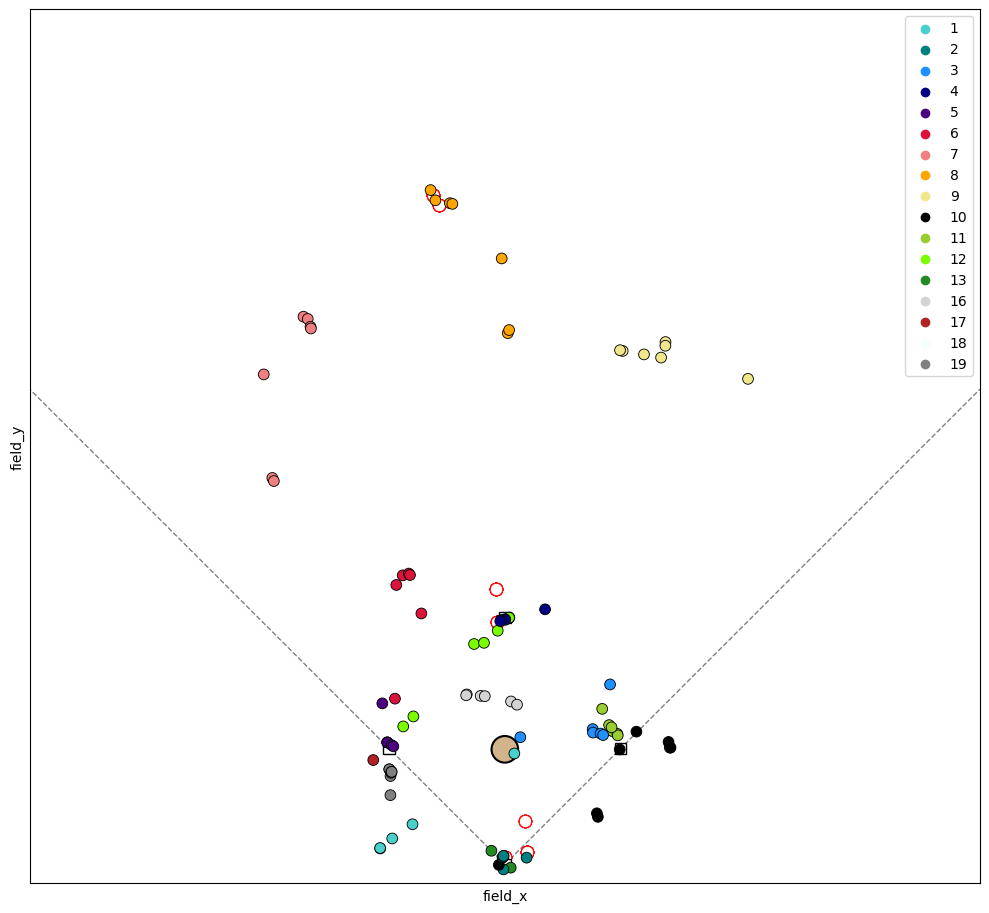

In [10]:
player_pos_colors = {7: 'lightcoral', 
                 8: 'orange', 
                 9: 'khaki', 
                 1: 'mediumturquoise', 
                 2: 'teal', 
                 3: 'dodgerblue', 
                 4: 'navy', 
                 5: 'indigo', 
                 6: 'crimson', 
                 10: 'black', 
                 11: 'yellowgreen', 
                 12: 'lawngreen',
                 13: 'forestgreen',
                 14: 'silver',
                 16: 'lightgray',
                 17: 'firebrick',
                 18: 'mintcream',
                 19: 'gray'}


import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 12))

example_play = first_or_second[first_or_second_ppos['play_id'] == 45]
X = example_play['field_x']
Y = example_play['field_y']
sns.scatterplot(ax=ax, x=X, y=Y, hue = example_play['player_position'], palette = player_pos_colors, edgecolor = 'black', alpha = 1, zorder = 2, s = 60)
sns.scatterplot(ax=ax, x = example_play['ball_position_x'], y = example_play['ball_position_y'], edgecolor = 'red', s = 80, color = 'white')

#Chatted seaborn baseball diagram
base_coords = [(0, 0), (61, 61), (0, 130), (-61, 61)]
for x, y in base_coords:
    base = plt.Rectangle((x-3, y-3), 6, 6, color='white', ec='black', zorder=1)
    ax.add_patch(base)

# Foul lines: from home to left and right field corners
ax.plot([0, -250], [0, 250], color='gray', linestyle='--', linewidth=1, zorder=0)  # Left field line
ax.plot([0, 250], [0, 250], color='gray', linestyle='--', linewidth=1, zorder=0)   # Right field line

# Pitcher's mound at (0, 60.5)
mound = plt.Circle((0, 60.5), 7, color='tan', ec='black', lw=1.5, zorder=1)
ax.add_patch(mound)

# Outfield arc centered at home, spanning from left to right field
    
ax.set_xlim(-250, 250)
ax.set_ylim(-10, 450)
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

## Current Status:

During the second webinar, they said that the timestamp data could potentially be messy. It seems that in the above df, the game_info timestamp isn't lining up with the player_pos timestamp such that it includes all the rows from the player_pos df. 

Right now, for every play, the runner timestamp is questionable, with runners skipping around the baseline. 

If this doesn't change when the new data comes in, we'll pivot.

### Next Steps:

Goals:
- Query for plays where the runner on second or first goes home
    - Don't need to exclude plays such as: R2 -> Home & R1 -> 3rd
- Merge first_to_third and the above described datasets to use as training data for our continuous extra base safe probability model. 
    - Should train on those scenarios (only scenarios we care about and only scenarios where runners on base and they take an extra base)

Continue to work on this query to find plays where the runner on 1st or 2nd attempts to score. Because there's no indicator that the runner crossed home plate, we'll need to use player_pos data to estimate when the runner crosses home, if they're safe or out, and what the threshold is on the baseline for "attempting to score". 

Ideas: 
- If the ball reaches a certain radius before the runner reaches a certain radius, they're out and vice versa. 
- If the runner crosses a certain (x, y) threshold, they'll be considered to be attempting to score.

### Assumptions

Let's assume that if third base is around (-61, 61) on either side of the y-axis. Then, assuming that the decision point for coming home is the half-way point down the baseline, that would be at about (-35, 35). 

In [11]:
#function to find whether or not the runner on 1st "passed" the threshold
def passed_threshold_1(x, y, x_threshold, y_threshold):
    return ((x >= x_threshold) & (y <= y_threshold)).any()

x1 = first_or_second[first_or_second['player_position'] == 11]['field_x']
y1 = first_or_second[first_or_second['player_position'] == 11]['field_y'] 

passed1 = first_or_second.groupby('play_id').apply(lambda group: passed_threshold_1(x1, y1, -35, 35)).rename('first_to_home')

first_coming_home = first_or_second.merge(passed1, on = 'play_id')


#Same thing for runner on 2nd
def passed_threshold_2(x, y, x_threshold, y_threshold):
    return ((x >= x_threshold) & (y <= y_threshold)).any()

x2 = first_coming_home[first_coming_home['player_position'] == 12]['field_x']
y2 = first_coming_home[first_coming_home['player_position'] == 12]['field_y'] 

passed2 = first_coming_home.groupby('play_id').apply(lambda group: passed_threshold_2(x2, y2, -35, 35)).rename('second_to_home')

first_or_second_coming_home = first_coming_home.merge(passed2, on = 'play_id')
first_or_second_coming_home


,game_str,play_id,timestamp,home_team,away_team,at_bat,play_per_game,top_bottom_inning,pitcher,catcher,...,event_code,first_to_third,player_position,field_x,field_y,ball_position_x,ball_position_y,ball_position_z,first_to_home,second_to_home
0,y1_d070_ACN_QEA,14,282987,QEA,ACN,2,14,top,QEA-0175,QEA-0120,...,4,False,1,-0.2790,55.1760,-0.348351,0.790455,2.624541,False,True
1,y1_d070_ACN_QEA,14,282987,QEA,ACN,2,14,top,QEA-0175,QEA-0120,...,4,False,2,-3.1074,-3.4962,-0.348351,0.790455,2.624541,False,True
2,y1_d070_ACN_QEA,14,282987,QEA,ACN,2,14,top,QEA-0175,QEA-0120,...,4,False,3,57.7971,64.5051,-0.348351,0.790455,2.624541,False,True
3,y1_d070_ACN_QEA,14,282987,QEA,ACN,2,14,top,QEA-0175,QEA-0120,...,4,False,4,22.1529,137.5215,-0.348351,0.790455,2.624541,False,True
4,y1_d070_ACN_QEA,14,282987,QEA,ACN,2,14,top,QEA-0175,QEA-0120,...,4,False,5,-64.2399,97.0239,-0.348351,0.790455,2.624541,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1618,y1_d070_ACN_QEA,297,9943237,QEA,ACN,71,297,top,QEA-0108,QEA-0120,...,2,False,8,46.3929,288.4752,-17.038500,71.086500,2.128119,False,True
1619,y1_d070_ACN_QEA,297,9943237,QEA,ACN,71,297,top,QEA-0108,QEA-0120,...,2,False,9,43.2600,320.8551,-17.038500,71.086500,2.128119,False,True
1620,y1_d070_ACN_QEA,297,9943237,QEA,ACN,71,297,top,QEA-0108,QEA-0120,...,2,False,10,56.1486,73.8765,-17.038500,71.086500,2.128119,False,True
1621,y1_d070_ACN_QEA,297,9943237,QEA,ACN,71,297,top,QEA-0108,QEA-0120,...,2,False,17,-12.0753,132.9483,-17.038500,71.086500,2.128119,False,True
